In [492]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import random
import torch.utils.data as data_utils
import string
import re
import pdb
import os
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import time
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [539]:
# Load language pairs downloaded from http://www.manythings.org/anki/

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (Remain %s)' % (asMinutes(s), asMinutes(rs))


In [347]:
SOS_token = 'SOS' # start of sentence
EOS_token = 'EOS' # end of sentence
PAD_token = 'PAD' # paddling


class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []
        self.add_sentence(' '.join([SOS_token, EOS_token, PAD_token]))
        
    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)
        
    def add_word(self, word):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
        return self.word2idx[word]

    def __len__(self):
        return len(self.idx2word)
    
class Corpus(object):
    def __init__(self, vocabulary=None, lines=[]):
        print("Initializing Corpus from file")
        self.vocabulary = vocabulary
        self.data = self.tokenize(lines)            

    def tokenize(self, lines):
        """
        Tokenizeslines
        Return (number of pairs, sequence, 1)
        UnicodeDecodeErrors are ignored 
        """
        
        nlines = len(lines)
        print ("File has {} lines".format(nlines))
        
        if self.vocabulary == None:
            self.vocabulary = Vocabulary()
            # Construct vocabulary for the corpus
            print("Constructing Vocabulary")
            for line in lines:
                self.vocabulary.add_sentence(line)

        print("Tokenizing file")                
        # Tokenize file content
        ids = [[self.vocabulary.word2idx[word] for word in line.split(' ')] for line in lines]
        return ids

Initializing Corpus from file
File has 135842 lines
Constructing Vocabulary
Tokenizing file
Initializing Corpus from file
File has 135842 lines
Constructing Vocabulary
Tokenizing file
Done


In [565]:
class EncoderRNN(nn.Module):
    '''
    Input: (batch, seq, ids)
    Output:
    '''
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        '''Weights'''
        self.embed = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

    def forward(self, inputs):
        inputs = self.embed(inputs)
        h, h_last = self.gru(inputs) # outp
        return h, h_last


class DecoderRNN(nn.Module):
    '''
    Input: (batch, embeddings), hiddens
    Output: (batch, seq, ids)
    '''
    def __init__(self, input_size, hidden_size):
        super(DecoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        '''Weights'''
        self.embed = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.relu = nn.ReLU()
        self.h2o = nn.Linear(hidden_size, input_size)

    def forward(self, inputs, hiddens):
        inputs = self.embed(inputs)
        h, h_last = self.gru(inputs, hiddens)
        relu_output = self.relu(h)
        return F.log_softmax(self.h2o(relu_output), 2), h_last

In [612]:
def shuffle(lang1, lang2):
    combined = list(zip(lang1, lang2))
    random.shuffle(combined)
    a, b = zip(*combined)
    return list(a), list(b)
    
def sliceList(lang1, lang2, ratio=0.8):
    sz_ = int(len(lang1) * 0.8)
    return (lang1[0: sz_], lang2[0: sz_]), (lang1[sz_:], lang2[sz_:])

def max_length_list_in_lists(lists):
    return max(lists, key=len)

def padding(lists):
    SOS = corpus1.vocabulary.word2idx[SOS_token]
    EOS = corpus1.vocabulary.word2idx[EOS_token]
    PAD = corpus1.vocabulary.word2idx[PAD_token]
    
    sz = len(max_length_list_in_lists(lists)) + 2 # plus SOS and EOS
    for idx, l in enumerate(lists):
        l = [SOS] + l + [EOS]
        sz_ = len(l)
        lists[idx] = l + (sz - sz_) * [PAD]
    return lists


    
train_lang1 = corpus1.data
train_lang2 = corpus2.data

In [613]:
# Read the file and split into lines
lines = open('./data/eng-fra.txt', encoding='utf-8').read().strip().split('\n')

# Split every line into pairs and normalize
lang1 = [normalizeString(l.split('\t')[0])[:10] for l in lines]
lang2 = [normalizeString(l.split('\t')[1])[:10] for l in lines]

corpus1 = Corpus(lines=lang1)
corpus2 = Corpus(lines=lang2)

print ("Done")

Initializing Corpus from file
File has 135842 lines
Constructing Vocabulary
Tokenizing file
Initializing Corpus from file
File has 135842 lines
Constructing Vocabulary
Tokenizing file
Done


In [614]:
import copy

train_lang1 = copy.deepcopy(corpus1.data)
train_lang2 = copy.deepcopy(corpus2.data)


train_lang1, train_lang2 = shuffle(train_lang1, train_lang2)
trainset, validset = sliceList(padding(train_lang1), padding(train_lang2), ratio=0.8)

train_dataset = torch.utils.data.TensorDataset(torch.LongTensor(trainset[0]), torch.LongTensor(trainset[1]))
valid_dataset = torch.utils.data.TensorDataset(torch.LongTensor(validset[0]), torch.LongTensor(validset[1]))

In [620]:
def evaluate(encoder, decoder, text):
    encoder_input = SOS_token + ' ' + text + ' ' + EOS_token
    encoder_input_tensor = torch.LongTensor([corpus1.vocabulary.word2idx[word] for word in encoder_input.split(' ')]).unsqueeze(0)
    _, hiddens = encoder(encoder_input_tensor)
    decoder_input = [SOS_token]
    idx = 0
    max_iter = 10
    while(1):
        decoder_input_tensor = torch.LongTensor([corpus2.vocabulary.word2idx[t] for t in decoder_input]).unsqueeze(0)
        output, h_last = decoder(decoder_input_tensor, hiddens)
        topv, topi = torch.topk(output[0][-1], 1)    
        curr = corpus2.vocabulary.idx2word[topi]
        decoder_input.append(curr)  
        if curr == EOS_token or idx == max_iter:
            break
        hiddens = h_last
        idx += 1 
    print (decoder_input)

In [650]:
hidden_size = 256
lr = 0.01
encoder = EncoderRNN(len(corpus1.vocabulary), hidden_size)
decoder = DecoderRNN(len(corpus2.vocabulary), hidden_size)

print_every = 10
evaluate_every = 100
save_every = 20
running_loss = 0
epochs = 30

''' training dataloader '''
batch_size = 50
dataloader = torch.utils.data.DataLoader(
                train_dataset,
                batch_size=batch_size,
                shuffle=True,
                num_workers=1,
                drop_last=True,
                pin_memory=True)

criterion = nn.NLLLoss(reduction='elementwise_mean').to(device)


encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)


niters = int(len(trainset[0]) / batch_size)

def get_loss(target, output):
    '''
    Teacher forcing ? 
    '''
    loss = 0
    for di in range(target.shape[1]-1):
        loss += criterion(output[:,di,:], target[:,di+1])
    return loss

start = time.time()
losses = []
for epoch in range(1, epochs+1): 
    for batch_idx, data in enumerate(dataloader, 1):
            input, target = data  
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            # Encoder
            _, hidden = encoder(input)

            # Decoder
            output, _ = decoder(target, hidden)
            
            # Loss 
            loss = get_loss(target, output)
            running_loss += loss.item()

            # Update Weight
            loss.backward()
            
            encoder_optimizer.step()
            decoder_optimizer.step()

            if batch_idx % print_every == 0:
                print("Epoch : {} / {}, Iteration {} / {}, Loss every {} iteration :  {}, Takes {}".format(epoch, epochs, batch_idx, niters, print_every, running_loss / print_every, timeSince(start, batch_idx / niters)))
                running_loss = 0
                
            if batch_idx % evaluate_every == 0:
                evaluate(encoder, decoder, 'stop it !')
                
            if batch_idx % save_every == 0:
                losses.append(loss.item())

Epoch : 1 / 30, Iteration 10 / 2173, Loss every 10 iteration :  27.709895896911622, Takes 0m 3s (Remain 13m 55s)
Epoch : 1 / 30, Iteration 20 / 2173, Loss every 10 iteration :  19.027542686462404, Takes 0m 8s (Remain 15m 10s)
Epoch : 1 / 30, Iteration 30 / 2173, Loss every 10 iteration :  17.301903629302977, Takes 0m 13s (Remain 15m 37s)
Epoch : 1 / 30, Iteration 40 / 2173, Loss every 10 iteration :  16.13807134628296, Takes 0m 18s (Remain 16m 4s)
Epoch : 1 / 30, Iteration 50 / 2173, Loss every 10 iteration :  15.037791633605957, Takes 0m 23s (Remain 16m 23s)
Epoch : 1 / 30, Iteration 60 / 2173, Loss every 10 iteration :  14.462069129943847, Takes 0m 28s (Remain 16m 49s)
Epoch : 1 / 30, Iteration 70 / 2173, Loss every 10 iteration :  13.681765365600587, Takes 0m 34s (Remain 17m 21s)
Epoch : 1 / 30, Iteration 80 / 2173, Loss every 10 iteration :  13.39353904724121, Takes 0m 39s (Remain 17m 18s)
Epoch : 1 / 30, Iteration 90 / 2173, Loss every 10 iteration :  13.224739742279052, Takes 0m 

Epoch : 1 / 30, Iteration 710 / 2173, Loss every 10 iteration :  10.497777652740478, Takes 6m 36s (Remain 13m 36s)
Epoch : 1 / 30, Iteration 720 / 2173, Loss every 10 iteration :  10.409220123291016, Takes 6m 42s (Remain 13m 32s)
Epoch : 1 / 30, Iteration 730 / 2173, Loss every 10 iteration :  10.334537982940674, Takes 6m 48s (Remain 13m 27s)
Epoch : 1 / 30, Iteration 740 / 2173, Loss every 10 iteration :  10.588111972808838, Takes 6m 55s (Remain 13m 24s)
Epoch : 1 / 30, Iteration 750 / 2173, Loss every 10 iteration :  10.463863086700439, Takes 7m 1s (Remain 13m 20s)
Epoch : 1 / 30, Iteration 760 / 2173, Loss every 10 iteration :  10.624002742767335, Takes 7m 8s (Remain 13m 16s)
Epoch : 1 / 30, Iteration 770 / 2173, Loss every 10 iteration :  10.259696960449219, Takes 7m 14s (Remain 13m 11s)
Epoch : 1 / 30, Iteration 780 / 2173, Loss every 10 iteration :  10.914250373840332, Takes 7m 21s (Remain 13m 8s)
Epoch : 1 / 30, Iteration 790 / 2173, Loss every 10 iteration :  10.584755134582519

Epoch : 1 / 30, Iteration 1410 / 2173, Loss every 10 iteration :  9.919873714447021, Takes 15m 6s (Remain 8m 10s)
Epoch : 1 / 30, Iteration 1420 / 2173, Loss every 10 iteration :  9.540005493164063, Takes 15m 12s (Remain 8m 3s)
Epoch : 1 / 30, Iteration 1430 / 2173, Loss every 10 iteration :  10.458710670471191, Takes 15m 18s (Remain 7m 57s)
Epoch : 1 / 30, Iteration 1440 / 2173, Loss every 10 iteration :  10.25800952911377, Takes 15m 23s (Remain 7m 50s)
Epoch : 1 / 30, Iteration 1450 / 2173, Loss every 10 iteration :  9.270816612243653, Takes 15m 29s (Remain 7m 43s)
Epoch : 1 / 30, Iteration 1460 / 2173, Loss every 10 iteration :  9.449817943572999, Takes 15m 34s (Remain 7m 36s)
Epoch : 1 / 30, Iteration 1470 / 2173, Loss every 10 iteration :  9.700641345977782, Takes 15m 40s (Remain 7m 29s)
Epoch : 1 / 30, Iteration 1480 / 2173, Loss every 10 iteration :  9.841423273086548, Takes 15m 46s (Remain 7m 23s)
Epoch : 1 / 30, Iteration 1490 / 2173, Loss every 10 iteration :  9.4961134910583

Epoch : 1 / 30, Iteration 2110 / 2173, Loss every 10 iteration :  9.1823251247406, Takes 22m 24s (Remain 0m 40s)
Epoch : 1 / 30, Iteration 2120 / 2173, Loss every 10 iteration :  9.310371398925781, Takes 22m 31s (Remain 0m 33s)
Epoch : 1 / 30, Iteration 2130 / 2173, Loss every 10 iteration :  9.234285449981689, Takes 22m 37s (Remain 0m 27s)
Epoch : 1 / 30, Iteration 2140 / 2173, Loss every 10 iteration :  9.171115398406982, Takes 22m 43s (Remain 0m 21s)
Epoch : 1 / 30, Iteration 2150 / 2173, Loss every 10 iteration :  9.130369567871094, Takes 22m 50s (Remain 0m 14s)
Epoch : 1 / 30, Iteration 2160 / 2173, Loss every 10 iteration :  9.044835138320924, Takes 22m 57s (Remain 0m 8s)
Epoch : 1 / 30, Iteration 2170 / 2173, Loss every 10 iteration :  9.029589080810547, Takes 23m 3s (Remain 0m 1s)
Epoch : 2 / 30, Iteration 10 / 2173, Loss every 10 iteration :  11.101989603042602, Takes 23m 12s (Remain 5021m 3s)
Epoch : 2 / 30, Iteration 20 / 2173, Loss every 10 iteration :  8.29289755821228, Ta

Epoch : 2 / 30, Iteration 640 / 2173, Loss every 10 iteration :  8.381459760665894, Takes 30m 27s (Remain 72m 57s)
Epoch : 2 / 30, Iteration 650 / 2173, Loss every 10 iteration :  8.608782100677491, Takes 30m 34s (Remain 71m 37s)
Epoch : 2 / 30, Iteration 660 / 2173, Loss every 10 iteration :  8.756437397003173, Takes 30m 41s (Remain 70m 21s)
Epoch : 2 / 30, Iteration 670 / 2173, Loss every 10 iteration :  8.560457372665406, Takes 30m 47s (Remain 69m 5s)
Epoch : 2 / 30, Iteration 680 / 2173, Loss every 10 iteration :  8.592444849014282, Takes 30m 54s (Remain 67m 51s)
Epoch : 2 / 30, Iteration 690 / 2173, Loss every 10 iteration :  8.534458541870118, Takes 31m 0s (Remain 66m 38s)
Epoch : 2 / 30, Iteration 700 / 2173, Loss every 10 iteration :  8.551895189285279, Takes 31m 7s (Remain 65m 29s)
['SOS', 'salut', 'a', 'EOS']
Epoch : 2 / 30, Iteration 710 / 2173, Loss every 10 iteration :  8.289562368392945, Takes 31m 14s (Remain 64m 22s)
Epoch : 2 / 30, Iteration 720 / 2173, Loss every 10 it

Epoch : 2 / 30, Iteration 1340 / 2173, Loss every 10 iteration :  8.593746280670166, Takes 38m 47s (Remain 24m 6s)
Epoch : 2 / 30, Iteration 1350 / 2173, Loss every 10 iteration :  8.376730632781982, Takes 38m 56s (Remain 23m 44s)
Epoch : 2 / 30, Iteration 1360 / 2173, Loss every 10 iteration :  8.909570789337158, Takes 39m 3s (Remain 23m 21s)
Epoch : 2 / 30, Iteration 1370 / 2173, Loss every 10 iteration :  8.464663028717041, Takes 39m 10s (Remain 22m 57s)
Epoch : 2 / 30, Iteration 1380 / 2173, Loss every 10 iteration :  8.761091899871825, Takes 39m 18s (Remain 22m 35s)
Epoch : 2 / 30, Iteration 1390 / 2173, Loss every 10 iteration :  8.777291679382325, Takes 39m 27s (Remain 22m 13s)
Epoch : 2 / 30, Iteration 1400 / 2173, Loss every 10 iteration :  8.651577043533326, Takes 39m 34s (Remain 21m 51s)
['SOS', 'cessez', 'de', 'EOS']
Epoch : 2 / 30, Iteration 1410 / 2173, Loss every 10 iteration :  8.922072315216065, Takes 39m 41s (Remain 21m 28s)
Epoch : 2 / 30, Iteration 1420 / 2173, Loss

Epoch : 2 / 30, Iteration 2040 / 2173, Loss every 10 iteration :  8.099403953552246, Takes 48m 59s (Remain 3m 11s)
Epoch : 2 / 30, Iteration 2050 / 2173, Loss every 10 iteration :  8.407635164260864, Takes 49m 10s (Remain 2m 57s)
Epoch : 2 / 30, Iteration 2060 / 2173, Loss every 10 iteration :  8.748337173461914, Takes 49m 23s (Remain 2m 42s)
Epoch : 2 / 30, Iteration 2070 / 2173, Loss every 10 iteration :  8.471384239196777, Takes 49m 35s (Remain 2m 28s)
Epoch : 2 / 30, Iteration 2080 / 2173, Loss every 10 iteration :  8.17774338722229, Takes 49m 49s (Remain 2m 13s)
Epoch : 2 / 30, Iteration 2090 / 2173, Loss every 10 iteration :  8.021811389923096, Takes 50m 0s (Remain 1m 59s)
Epoch : 2 / 30, Iteration 2100 / 2173, Loss every 10 iteration :  8.538620710372925, Takes 50m 12s (Remain 1m 44s)
['SOS', 'arrete', 'de', 'EOS']
Epoch : 2 / 30, Iteration 2110 / 2173, Loss every 10 iteration :  8.360693216323853, Takes 50m 23s (Remain 1m 30s)
Epoch : 2 / 30, Iteration 2120 / 2173, Loss every 1

Epoch : 3 / 30, Iteration 570 / 2173, Loss every 10 iteration :  7.903067255020142, Takes 63m 36s (Remain 178m 51s)
Epoch : 3 / 30, Iteration 580 / 2173, Loss every 10 iteration :  7.643436622619629, Takes 63m 46s (Remain 175m 9s)
Epoch : 3 / 30, Iteration 590 / 2173, Loss every 10 iteration :  7.49586853981018, Takes 63m 55s (Remain 171m 31s)
Epoch : 3 / 30, Iteration 600 / 2173, Loss every 10 iteration :  7.84155158996582, Takes 64m 6s (Remain 168m 4s)
['SOS', 'facebook', '', 'EOS']
Epoch : 3 / 30, Iteration 610 / 2173, Loss every 10 iteration :  7.791477537155151, Takes 64m 20s (Remain 164m 52s)
Epoch : 3 / 30, Iteration 620 / 2173, Loss every 10 iteration :  7.933723402023316, Takes 64m 31s (Remain 161m 37s)
Epoch : 3 / 30, Iteration 630 / 2173, Loss every 10 iteration :  7.808666038513183, Takes 64m 40s (Remain 158m 25s)
Epoch : 3 / 30, Iteration 640 / 2173, Loss every 10 iteration :  8.088987922668457, Takes 64m 55s (Remain 155m 30s)
Epoch : 3 / 30, Iteration 650 / 2173, Loss eve

Epoch : 3 / 30, Iteration 1270 / 2173, Loss every 10 iteration :  8.251787519454956, Takes 77m 44s (Remain 55m 16s)
Epoch : 3 / 30, Iteration 1280 / 2173, Loss every 10 iteration :  7.948345375061035, Takes 77m 58s (Remain 54m 23s)
Epoch : 3 / 30, Iteration 1290 / 2173, Loss every 10 iteration :  7.704509115219116, Takes 78m 10s (Remain 53m 30s)
Epoch : 3 / 30, Iteration 1300 / 2173, Loss every 10 iteration :  7.897729110717774, Takes 78m 24s (Remain 52m 39s)
['SOS', 'salut', 'en', 'EOS']
Epoch : 3 / 30, Iteration 1310 / 2173, Loss every 10 iteration :  8.089715433120727, Takes 78m 41s (Remain 51m 50s)
Epoch : 3 / 30, Iteration 1320 / 2173, Loss every 10 iteration :  8.10929536819458, Takes 78m 58s (Remain 51m 2s)
Epoch : 3 / 30, Iteration 1330 / 2173, Loss every 10 iteration :  7.67974362373352, Takes 79m 14s (Remain 50m 13s)
Epoch : 3 / 30, Iteration 1340 / 2173, Loss every 10 iteration :  7.718787384033203, Takes 79m 29s (Remain 49m 24s)
Epoch : 3 / 30, Iteration 1350 / 2173, Loss e

Epoch : 3 / 30, Iteration 1970 / 2173, Loss every 10 iteration :  8.053897142410278, Takes 91m 43s (Remain 9m 27s)
Epoch : 3 / 30, Iteration 1980 / 2173, Loss every 10 iteration :  7.951398754119873, Takes 91m 53s (Remain 8m 57s)
Epoch : 3 / 30, Iteration 1990 / 2173, Loss every 10 iteration :  8.135745000839233, Takes 92m 2s (Remain 8m 27s)
Epoch : 3 / 30, Iteration 2000 / 2173, Loss every 10 iteration :  8.339213466644287, Takes 92m 13s (Remain 7m 58s)
['SOS', 'arretez', '!', 'EOS']
Epoch : 3 / 30, Iteration 2010 / 2173, Loss every 10 iteration :  8.002161502838135, Takes 92m 23s (Remain 7m 29s)
Epoch : 3 / 30, Iteration 2020 / 2173, Loss every 10 iteration :  8.169183731079102, Takes 92m 33s (Remain 7m 0s)
Epoch : 3 / 30, Iteration 2030 / 2173, Loss every 10 iteration :  7.595700979232788, Takes 92m 42s (Remain 6m 31s)
Epoch : 3 / 30, Iteration 2040 / 2173, Loss every 10 iteration :  7.923006057739258, Takes 92m 51s (Remain 6m 3s)
Epoch : 3 / 30, Iteration 2050 / 2173, Loss every 10

Epoch : 4 / 30, Iteration 500 / 2173, Loss every 10 iteration :  7.500573348999024, Takes 103m 7s (Remain 345m 3s)
['SOS', 'salut', 'simp', 'EOS']
Epoch : 4 / 30, Iteration 510 / 2173, Loss every 10 iteration :  7.603140211105346, Takes 103m 18s (Remain 336m 50s)
Epoch : 4 / 30, Iteration 520 / 2173, Loss every 10 iteration :  7.696411991119385, Takes 103m 29s (Remain 329m 0s)
Epoch : 4 / 30, Iteration 530 / 2173, Loss every 10 iteration :  7.523621654510498, Takes 103m 42s (Remain 321m 28s)
Epoch : 4 / 30, Iteration 540 / 2173, Loss every 10 iteration :  7.414174604415893, Takes 103m 52s (Remain 314m 7s)
Epoch : 4 / 30, Iteration 550 / 2173, Loss every 10 iteration :  7.124635124206543, Takes 104m 2s (Remain 307m 0s)
Epoch : 4 / 30, Iteration 560 / 2173, Loss every 10 iteration :  7.711185312271118, Takes 104m 13s (Remain 300m 11s)
Epoch : 4 / 30, Iteration 570 / 2173, Loss every 10 iteration :  7.4548131942749025, Takes 104m 26s (Remain 293m 41s)
Epoch : 4 / 30, Iteration 580 / 2173,

Epoch : 4 / 30, Iteration 1190 / 2173, Loss every 10 iteration :  7.854115676879883, Takes 115m 50s (Remain 95m 41s)
Epoch : 4 / 30, Iteration 1200 / 2173, Loss every 10 iteration :  7.730592966079712, Takes 116m 2s (Remain 94m 5s)
['SOS', 'arretez', '!', 'EOS']
Epoch : 4 / 30, Iteration 1210 / 2173, Loss every 10 iteration :  7.725732278823853, Takes 116m 13s (Remain 92m 29s)
Epoch : 4 / 30, Iteration 1220 / 2173, Loss every 10 iteration :  7.5906391620635985, Takes 116m 23s (Remain 90m 55s)
Epoch : 4 / 30, Iteration 1230 / 2173, Loss every 10 iteration :  7.438286876678466, Takes 116m 34s (Remain 89m 22s)
Epoch : 4 / 30, Iteration 1240 / 2173, Loss every 10 iteration :  7.421850681304932, Takes 116m 45s (Remain 87m 51s)
Epoch : 4 / 30, Iteration 1250 / 2173, Loss every 10 iteration :  7.631336069107055, Takes 116m 56s (Remain 86m 20s)
Epoch : 4 / 30, Iteration 1260 / 2173, Loss every 10 iteration :  7.412017869949341, Takes 117m 7s (Remain 84m 51s)
Epoch : 4 / 30, Iteration 1270 / 21

Epoch : 4 / 30, Iteration 1880 / 2173, Loss every 10 iteration :  7.56729531288147, Takes 127m 50s (Remain 19m 55s)
Epoch : 4 / 30, Iteration 1890 / 2173, Loss every 10 iteration :  7.803321123123169, Takes 128m 0s (Remain 19m 10s)
Epoch : 4 / 30, Iteration 1900 / 2173, Loss every 10 iteration :  7.656104373931885, Takes 128m 10s (Remain 18m 24s)
['SOS', 'arretez', 'de', 'EOS']
Epoch : 4 / 30, Iteration 1910 / 2173, Loss every 10 iteration :  7.158943319320679, Takes 128m 20s (Remain 17m 40s)
Epoch : 4 / 30, Iteration 1920 / 2173, Loss every 10 iteration :  7.383843040466308, Takes 128m 29s (Remain 16m 55s)
Epoch : 4 / 30, Iteration 1930 / 2173, Loss every 10 iteration :  7.93183708190918, Takes 128m 38s (Remain 16m 11s)
Epoch : 4 / 30, Iteration 1940 / 2173, Loss every 10 iteration :  7.472152137756348, Takes 128m 49s (Remain 15m 28s)
Epoch : 4 / 30, Iteration 1950 / 2173, Loss every 10 iteration :  7.700886821746826, Takes 128m 58s (Remain 14m 45s)
Epoch : 4 / 30, Iteration 1960 / 21

Epoch : 5 / 30, Iteration 400 / 2173, Loss every 10 iteration :  7.348881816864013, Takes 139m 15s (Remain 617m 17s)
['SOS', 'arretez', '', 'EOS']
Epoch : 5 / 30, Iteration 410 / 2173, Loss every 10 iteration :  7.096558952331543, Takes 139m 25s (Remain 599m 33s)
Epoch : 5 / 30, Iteration 420 / 2173, Loss every 10 iteration :  7.887730693817138, Takes 139m 35s (Remain 582m 38s)
Epoch : 5 / 30, Iteration 430 / 2173, Loss every 10 iteration :  7.504136180877685, Takes 139m 45s (Remain 566m 31s)
Epoch : 5 / 30, Iteration 440 / 2173, Loss every 10 iteration :  7.421626949310303, Takes 139m 55s (Remain 551m 7s)
Epoch : 5 / 30, Iteration 450 / 2173, Loss every 10 iteration :  7.65208477973938, Takes 140m 5s (Remain 536m 24s)
Epoch : 5 / 30, Iteration 460 / 2173, Loss every 10 iteration :  7.486612176895141, Takes 140m 16s (Remain 522m 21s)
Epoch : 5 / 30, Iteration 470 / 2173, Loss every 10 iteration :  7.542599773406982, Takes 140m 26s (Remain 508m 52s)
Epoch : 5 / 30, Iteration 480 / 2173,

Epoch : 5 / 30, Iteration 1090 / 2173, Loss every 10 iteration :  7.523453617095948, Takes 150m 40s (Remain 149m 42s)
Epoch : 5 / 30, Iteration 1100 / 2173, Loss every 10 iteration :  7.140494060516358, Takes 150m 50s (Remain 147m 8s)
['SOS', 'arretez', '!', 'EOS']
Epoch : 5 / 30, Iteration 1110 / 2173, Loss every 10 iteration :  7.442789602279663, Takes 151m 1s (Remain 144m 37s)
Epoch : 5 / 30, Iteration 1120 / 2173, Loss every 10 iteration :  7.533774518966675, Takes 151m 11s (Remain 142m 9s)
Epoch : 5 / 30, Iteration 1130 / 2173, Loss every 10 iteration :  7.738189935684204, Takes 151m 22s (Remain 139m 42s)
Epoch : 5 / 30, Iteration 1140 / 2173, Loss every 10 iteration :  7.249376583099365, Takes 151m 32s (Remain 137m 19s)
Epoch : 5 / 30, Iteration 1150 / 2173, Loss every 10 iteration :  7.318178653717041, Takes 151m 43s (Remain 134m 58s)
Epoch : 5 / 30, Iteration 1160 / 2173, Loss every 10 iteration :  7.468415546417236, Takes 151m 53s (Remain 132m 38s)
Epoch : 5 / 30, Iteration 11

Epoch : 5 / 30, Iteration 1770 / 2173, Loss every 10 iteration :  7.784244108200073, Takes 163m 21s (Remain 37m 11s)
Epoch : 5 / 30, Iteration 1780 / 2173, Loss every 10 iteration :  7.572111368179321, Takes 163m 33s (Remain 36m 6s)
Epoch : 5 / 30, Iteration 1790 / 2173, Loss every 10 iteration :  7.2877246856689455, Takes 163m 44s (Remain 35m 2s)
Epoch : 5 / 30, Iteration 1800 / 2173, Loss every 10 iteration :  7.3879601001739506, Takes 163m 55s (Remain 33m 58s)
['SOS', 'stoppez', '', 'EOS']
Epoch : 5 / 30, Iteration 1810 / 2173, Loss every 10 iteration :  7.542932987213135, Takes 164m 7s (Remain 32m 55s)
Epoch : 5 / 30, Iteration 1820 / 2173, Loss every 10 iteration :  6.976297235488891, Takes 164m 19s (Remain 31m 52s)
Epoch : 5 / 30, Iteration 1830 / 2173, Loss every 10 iteration :  7.46862416267395, Takes 164m 31s (Remain 30m 50s)
Epoch : 5 / 30, Iteration 1840 / 2173, Loss every 10 iteration :  7.204420185089111, Takes 164m 43s (Remain 29m 48s)
Epoch : 5 / 30, Iteration 1850 / 217

Epoch : 6 / 30, Iteration 290 / 2173, Loss every 10 iteration :  7.421032905578613, Takes 176m 40s (Remain 1147m 7s)
Epoch : 6 / 30, Iteration 300 / 2173, Loss every 10 iteration :  7.206081676483154, Takes 176m 51s (Remain 1104m 14s)
['SOS', '', 'il', 'simp', 'EOS']
Epoch : 6 / 30, Iteration 310 / 2173, Loss every 10 iteration :  7.306856155395508, Takes 177m 3s (Remain 1064m 1s)
Epoch : 6 / 30, Iteration 320 / 2173, Loss every 10 iteration :  7.3763891696929935, Takes 177m 15s (Remain 1026m 24s)
Epoch : 6 / 30, Iteration 330 / 2173, Loss every 10 iteration :  7.087502670288086, Takes 177m 27s (Remain 991m 4s)
Epoch : 6 / 30, Iteration 340 / 2173, Loss every 10 iteration :  6.718440866470337, Takes 177m 37s (Remain 957m 38s)
Epoch : 6 / 30, Iteration 350 / 2173, Loss every 10 iteration :  7.372917985916137, Takes 177m 48s (Remain 926m 9s)
Epoch : 6 / 30, Iteration 360 / 2173, Loss every 10 iteration :  7.3731176376342775, Takes 178m 0s (Remain 896m 26s)
Epoch : 6 / 30, Iteration 370 /

Epoch : 6 / 30, Iteration 980 / 2173, Loss every 10 iteration :  7.04540114402771, Takes 189m 16s (Remain 230m 24s)
Epoch : 6 / 30, Iteration 990 / 2173, Loss every 10 iteration :  7.522591543197632, Takes 189m 27s (Remain 226m 23s)
Epoch : 6 / 30, Iteration 1000 / 2173, Loss every 10 iteration :  7.480724954605103, Takes 189m 38s (Remain 222m 27s)
['SOS', 'stoppez', '!', 'EOS']
Epoch : 6 / 30, Iteration 1010 / 2173, Loss every 10 iteration :  7.766687250137329, Takes 189m 50s (Remain 218m 35s)
Epoch : 6 / 30, Iteration 1020 / 2173, Loss every 10 iteration :  7.128384733200074, Takes 190m 1s (Remain 214m 48s)
Epoch : 6 / 30, Iteration 1030 / 2173, Loss every 10 iteration :  7.439518976211548, Takes 190m 13s (Remain 211m 5s)
Epoch : 6 / 30, Iteration 1040 / 2173, Loss every 10 iteration :  7.192544984817505, Takes 190m 24s (Remain 207m 26s)
Epoch : 6 / 30, Iteration 1050 / 2173, Loss every 10 iteration :  7.810792398452759, Takes 190m 36s (Remain 203m 51s)
Epoch : 6 / 30, Iteration 1060

Epoch : 6 / 30, Iteration 1660 / 2173, Loss every 10 iteration :  7.3389373302459715, Takes 202m 15s (Remain 62m 30s)
Epoch : 6 / 30, Iteration 1670 / 2173, Loss every 10 iteration :  7.118544244766236, Takes 202m 27s (Remain 60m 58s)
Epoch : 6 / 30, Iteration 1680 / 2173, Loss every 10 iteration :  7.082428789138794, Takes 202m 38s (Remain 59m 28s)
Epoch : 6 / 30, Iteration 1690 / 2173, Loss every 10 iteration :  7.521311664581299, Takes 202m 50s (Remain 57m 58s)
Epoch : 6 / 30, Iteration 1700 / 2173, Loss every 10 iteration :  7.987183523178101, Takes 203m 2s (Remain 56m 29s)
['SOS', 'salut', 'es', 'EOS']
Epoch : 6 / 30, Iteration 1710 / 2173, Loss every 10 iteration :  7.7320314884185795, Takes 203m 13s (Remain 55m 1s)
Epoch : 6 / 30, Iteration 1720 / 2173, Loss every 10 iteration :  7.168818044662475, Takes 203m 25s (Remain 53m 34s)
Epoch : 6 / 30, Iteration 1730 / 2173, Loss every 10 iteration :  7.891028213500976, Takes 203m 37s (Remain 52m 8s)
Epoch : 6 / 30, Iteration 1740 / 21

Epoch : 7 / 30, Iteration 180 / 2173, Loss every 10 iteration :  7.014674997329712, Takes 215m 53s (Remain 2390m 24s)
Epoch : 7 / 30, Iteration 190 / 2173, Loss every 10 iteration :  7.200321817398072, Takes 216m 5s (Remain 2255m 14s)
Epoch : 7 / 30, Iteration 200 / 2173, Loss every 10 iteration :  7.172300910949707, Takes 216m 17s (Remain 2133m 40s)
['SOS', 'arrete', 'de', 'EOS']
Epoch : 7 / 30, Iteration 210 / 2173, Loss every 10 iteration :  7.1049586772918705, Takes 216m 28s (Remain 2023m 36s)
Epoch : 7 / 30, Iteration 220 / 2173, Loss every 10 iteration :  7.351082134246826, Takes 216m 40s (Remain 1923m 32s)
Epoch : 7 / 30, Iteration 230 / 2173, Loss every 10 iteration :  6.766600847244263, Takes 216m 52s (Remain 1832m 8s)
Epoch : 7 / 30, Iteration 240 / 2173, Loss every 10 iteration :  6.994068431854248, Takes 217m 4s (Remain 1748m 25s)
Epoch : 7 / 30, Iteration 250 / 2173, Loss every 10 iteration :  7.532065391540527, Takes 217m 16s (Remain 1671m 18s)
Epoch : 7 / 30, Iteration 2

Epoch : 7 / 30, Iteration 870 / 2173, Loss every 10 iteration :  7.247174596786499, Takes 229m 44s (Remain 344m 4s)
Epoch : 7 / 30, Iteration 880 / 2173, Loss every 10 iteration :  7.459906482696534, Takes 229m 56s (Remain 337m 51s)
Epoch : 7 / 30, Iteration 890 / 2173, Loss every 10 iteration :  6.875176429748535, Takes 230m 7s (Remain 331m 45s)
Epoch : 7 / 30, Iteration 900 / 2173, Loss every 10 iteration :  7.451203298568726, Takes 230m 20s (Remain 325m 47s)
['SOS', 'salut', 'en', 'EOS']
Epoch : 7 / 30, Iteration 910 / 2173, Loss every 10 iteration :  7.732711505889893, Takes 230m 32s (Remain 319m 57s)
Epoch : 7 / 30, Iteration 920 / 2173, Loss every 10 iteration :  7.542870426177979, Takes 230m 44s (Remain 314m 15s)
Epoch : 7 / 30, Iteration 930 / 2173, Loss every 10 iteration :  7.162442255020141, Takes 230m 56s (Remain 308m 40s)
Epoch : 7 / 30, Iteration 940 / 2173, Loss every 10 iteration :  7.269341993331909, Takes 231m 8s (Remain 303m 11s)
Epoch : 7 / 30, Iteration 950 / 2173,

Epoch : 7 / 30, Iteration 1550 / 2173, Loss every 10 iteration :  7.1896897315979, Takes 241m 58s (Remain 97m 15s)
Epoch : 7 / 30, Iteration 1560 / 2173, Loss every 10 iteration :  7.280001831054688, Takes 242m 6s (Remain 95m 8s)
Epoch : 7 / 30, Iteration 1570 / 2173, Loss every 10 iteration :  7.689092350006104, Takes 242m 15s (Remain 93m 2s)
Epoch : 7 / 30, Iteration 1580 / 2173, Loss every 10 iteration :  7.138326358795166, Takes 242m 23s (Remain 90m 58s)
Epoch : 7 / 30, Iteration 1590 / 2173, Loss every 10 iteration :  7.606614780426026, Takes 242m 31s (Remain 88m 55s)
Epoch : 7 / 30, Iteration 1600 / 2173, Loss every 10 iteration :  7.81804575920105, Takes 242m 39s (Remain 86m 54s)
['SOS', 'arrete', 'de', 'EOS']
Epoch : 7 / 30, Iteration 1610 / 2173, Loss every 10 iteration :  7.74327974319458, Takes 242m 48s (Remain 84m 54s)
Epoch : 7 / 30, Iteration 1620 / 2173, Loss every 10 iteration :  7.497993803024292, Takes 242m 56s (Remain 82m 55s)
Epoch : 7 / 30, Iteration 1630 / 2173, L

Epoch : 8 / 30, Iteration 70 / 2173, Loss every 10 iteration :  7.013802528381348, Takes 251m 19s (Remain 7550m 45s)
Epoch : 8 / 30, Iteration 80 / 2173, Loss every 10 iteration :  7.149541902542114, Takes 251m 28s (Remain 6579m 6s)
Epoch : 8 / 30, Iteration 90 / 2173, Loss every 10 iteration :  6.499745893478393, Takes 251m 36s (Remain 5823m 20s)
Epoch : 8 / 30, Iteration 100 / 2173, Loss every 10 iteration :  7.162716960906982, Takes 251m 44s (Remain 5218m 35s)
['SOS', 'arretez', '', 'EOS']
Epoch : 8 / 30, Iteration 110 / 2173, Loss every 10 iteration :  7.048294448852539, Takes 251m 52s (Remain 4723m 53s)
Epoch : 8 / 30, Iteration 120 / 2173, Loss every 10 iteration :  7.052635717391968, Takes 252m 0s (Remain 4311m 31s)
Epoch : 8 / 30, Iteration 130 / 2173, Loss every 10 iteration :  7.088431930541992, Takes 252m 9s (Remain 3962m 49s)
Epoch : 8 / 30, Iteration 140 / 2173, Loss every 10 iteration :  6.917575740814209, Takes 252m 17s (Remain 3663m 42s)
Epoch : 8 / 30, Iteration 150 / 

Epoch : 8 / 30, Iteration 750 / 2173, Loss every 10 iteration :  6.718007564544678, Takes 260m 50s (Remain 494m 53s)
Epoch : 8 / 30, Iteration 760 / 2173, Loss every 10 iteration :  7.211673021316528, Takes 260m 58s (Remain 485m 13s)
Epoch : 8 / 30, Iteration 770 / 2173, Loss every 10 iteration :  6.880224084854126, Takes 261m 7s (Remain 475m 46s)
Epoch : 8 / 30, Iteration 780 / 2173, Loss every 10 iteration :  7.105566596984863, Takes 261m 15s (Remain 466m 35s)
Epoch : 8 / 30, Iteration 790 / 2173, Loss every 10 iteration :  7.215922498703003, Takes 261m 25s (Remain 457m 38s)
Epoch : 8 / 30, Iteration 800 / 2173, Loss every 10 iteration :  7.081286287307739, Takes 261m 34s (Remain 448m 56s)
['SOS', 'salut', 'vous', 'EOS']
Epoch : 8 / 30, Iteration 810 / 2173, Loss every 10 iteration :  7.106521224975586, Takes 261m 45s (Remain 440m 27s)
Epoch : 8 / 30, Iteration 820 / 2173, Loss every 10 iteration :  7.095885610580444, Takes 261m 55s (Remain 432m 10s)
Epoch : 8 / 30, Iteration 830 / 2

Epoch : 8 / 30, Iteration 1430 / 2173, Loss every 10 iteration :  7.119543981552124, Takes 271m 31s (Remain 141m 4s)
Epoch : 8 / 30, Iteration 1440 / 2173, Loss every 10 iteration :  7.660760688781738, Takes 271m 41s (Remain 138m 17s)
Epoch : 8 / 30, Iteration 1450 / 2173, Loss every 10 iteration :  6.910190534591675, Takes 271m 50s (Remain 135m 32s)
Epoch : 8 / 30, Iteration 1460 / 2173, Loss every 10 iteration :  7.070339298248291, Takes 272m 0s (Remain 132m 50s)
Epoch : 8 / 30, Iteration 1470 / 2173, Loss every 10 iteration :  6.828942918777466, Takes 272m 10s (Remain 130m 9s)
Epoch : 8 / 30, Iteration 1480 / 2173, Loss every 10 iteration :  7.1074034690856935, Takes 272m 19s (Remain 127m 31s)
Epoch : 8 / 30, Iteration 1490 / 2173, Loss every 10 iteration :  7.268089675903321, Takes 272m 29s (Remain 124m 54s)
Epoch : 8 / 30, Iteration 1500 / 2173, Loss every 10 iteration :  7.516018581390381, Takes 272m 40s (Remain 122m 20s)
['SOS', 'salut', '!', 'EOS']
Epoch : 8 / 30, Iteration 151

Epoch : 8 / 30, Iteration 2120 / 2173, Loss every 10 iteration :  7.039073848724366, Takes 282m 25s (Remain 7m 3s)
Epoch : 8 / 30, Iteration 2130 / 2173, Loss every 10 iteration :  7.522804880142212, Takes 282m 34s (Remain 5m 42s)
Epoch : 8 / 30, Iteration 2140 / 2173, Loss every 10 iteration :  7.124106740951538, Takes 282m 43s (Remain 4m 21s)
Epoch : 8 / 30, Iteration 2150 / 2173, Loss every 10 iteration :  6.982929039001465, Takes 282m 53s (Remain 3m 1s)
Epoch : 8 / 30, Iteration 2160 / 2173, Loss every 10 iteration :  7.196439933776856, Takes 283m 1s (Remain 1m 42s)
Epoch : 8 / 30, Iteration 2170 / 2173, Loss every 10 iteration :  7.207784414291382, Takes 283m 11s (Remain 0m 23s)
Epoch : 9 / 30, Iteration 10 / 2173, Loss every 10 iteration :  9.111788892745972, Takes 283m 23s (Remain 61297m 15s)
Epoch : 9 / 30, Iteration 20 / 2173, Loss every 10 iteration :  7.1754035472869875, Takes 283m 32s (Remain 30523m 14s)
Epoch : 9 / 30, Iteration 30 / 2173, Loss every 10 iteration :  6.7078

Epoch : 9 / 30, Iteration 640 / 2173, Loss every 10 iteration :  7.30438232421875, Takes 292m 50s (Remain 701m 25s)
Epoch : 9 / 30, Iteration 650 / 2173, Loss every 10 iteration :  6.998535537719727, Takes 292m 58s (Remain 686m 27s)
Epoch : 9 / 30, Iteration 660 / 2173, Loss every 10 iteration :  6.885018062591553, Takes 293m 6s (Remain 671m 56s)
Epoch : 9 / 30, Iteration 670 / 2173, Loss every 10 iteration :  6.918499755859375, Takes 293m 15s (Remain 657m 51s)
Epoch : 9 / 30, Iteration 680 / 2173, Loss every 10 iteration :  6.715533256530762, Takes 293m 23s (Remain 644m 10s)
Epoch : 9 / 30, Iteration 690 / 2173, Loss every 10 iteration :  6.852144479751587, Takes 293m 32s (Remain 630m 53s)
Epoch : 9 / 30, Iteration 700 / 2173, Loss every 10 iteration :  7.0357622623443605, Takes 293m 40s (Remain 617m 58s)
['SOS', 'arretez', '!', 'EOS']
Epoch : 9 / 30, Iteration 710 / 2173, Loss every 10 iteration :  6.82814474105835, Takes 293m 48s (Remain 605m 25s)
Epoch : 9 / 30, Iteration 720 / 217

Epoch : 9 / 30, Iteration 1330 / 2173, Loss every 10 iteration :  7.246787738800049, Takes 302m 31s (Remain 191m 45s)
Epoch : 9 / 30, Iteration 1340 / 2173, Loss every 10 iteration :  7.291736316680908, Takes 302m 40s (Remain 188m 9s)
Epoch : 9 / 30, Iteration 1350 / 2173, Loss every 10 iteration :  7.524495220184326, Takes 302m 48s (Remain 184m 36s)
Epoch : 9 / 30, Iteration 1360 / 2173, Loss every 10 iteration :  7.461721134185791, Takes 302m 57s (Remain 181m 6s)
Epoch : 9 / 30, Iteration 1370 / 2173, Loss every 10 iteration :  7.0298240184783936, Takes 303m 5s (Remain 177m 39s)
Epoch : 9 / 30, Iteration 1380 / 2173, Loss every 10 iteration :  7.51512598991394, Takes 303m 14s (Remain 174m 15s)
Epoch : 9 / 30, Iteration 1390 / 2173, Loss every 10 iteration :  6.956623458862305, Takes 303m 23s (Remain 170m 53s)
Epoch : 9 / 30, Iteration 1400 / 2173, Loss every 10 iteration :  6.938290786743164, Takes 303m 31s (Remain 167m 35s)
['SOS', 'salut', 'sim', 'EOS']
Epoch : 9 / 30, Iteration 14

Epoch : 9 / 30, Iteration 2020 / 2173, Loss every 10 iteration :  7.2703540325164795, Takes 312m 18s (Remain 23m 39s)
Epoch : 9 / 30, Iteration 2030 / 2173, Loss every 10 iteration :  6.980155992507934, Takes 312m 26s (Remain 22m 0s)
Epoch : 9 / 30, Iteration 2040 / 2173, Loss every 10 iteration :  7.1397013664245605, Takes 312m 35s (Remain 20m 22s)
Epoch : 9 / 30, Iteration 2050 / 2173, Loss every 10 iteration :  7.222051954269409, Takes 312m 43s (Remain 18m 45s)
Epoch : 9 / 30, Iteration 2060 / 2173, Loss every 10 iteration :  7.458736181259155, Takes 312m 51s (Remain 17m 9s)
Epoch : 9 / 30, Iteration 2070 / 2173, Loss every 10 iteration :  7.43673415184021, Takes 313m 0s (Remain 15m 34s)
Epoch : 9 / 30, Iteration 2080 / 2173, Loss every 10 iteration :  7.301366329193115, Takes 313m 8s (Remain 14m 0s)
Epoch : 9 / 30, Iteration 2090 / 2173, Loss every 10 iteration :  7.231636571884155, Takes 313m 16s (Remain 12m 26s)
Epoch : 9 / 30, Iteration 2100 / 2173, Loss every 10 iteration :  7.

Epoch : 10 / 30, Iteration 530 / 2173, Loss every 10 iteration :  6.3608222007751465, Takes 321m 52s (Remain 997m 48s)
Epoch : 10 / 30, Iteration 540 / 2173, Loss every 10 iteration :  6.636694478988647, Takes 322m 0s (Remain 973m 47s)
Epoch : 10 / 30, Iteration 550 / 2173, Loss every 10 iteration :  7.230495357513428, Takes 322m 10s (Remain 950m 41s)
Epoch : 10 / 30, Iteration 560 / 2173, Loss every 10 iteration :  6.707536077499389, Takes 322m 18s (Remain 928m 22s)
Epoch : 10 / 30, Iteration 570 / 2173, Loss every 10 iteration :  6.794120264053345, Takes 322m 27s (Remain 906m 49s)
Epoch : 10 / 30, Iteration 580 / 2173, Loss every 10 iteration :  6.772241115570068, Takes 322m 36s (Remain 886m 2s)
Epoch : 10 / 30, Iteration 590 / 2173, Loss every 10 iteration :  6.645205450057984, Takes 322m 44s (Remain 865m 56s)
Epoch : 10 / 30, Iteration 600 / 2173, Loss every 10 iteration :  6.469799757003784, Takes 322m 53s (Remain 846m 31s)
['SOS', 'salut', '!', 'EOS']
Epoch : 10 / 30, Iteration 6

Epoch : 10 / 30, Iteration 1210 / 2173, Loss every 10 iteration :  6.963232040405273, Takes 331m 28s (Remain 263m 48s)
Epoch : 10 / 30, Iteration 1220 / 2173, Loss every 10 iteration :  6.833035230636597, Takes 331m 37s (Remain 259m 2s)
Epoch : 10 / 30, Iteration 1230 / 2173, Loss every 10 iteration :  7.385090780258179, Takes 331m 45s (Remain 254m 21s)
Epoch : 10 / 30, Iteration 1240 / 2173, Loss every 10 iteration :  7.250133609771728, Takes 331m 53s (Remain 249m 43s)
Epoch : 10 / 30, Iteration 1250 / 2173, Loss every 10 iteration :  7.1460634708404545, Takes 332m 2s (Remain 245m 10s)
Epoch : 10 / 30, Iteration 1260 / 2173, Loss every 10 iteration :  7.080975437164307, Takes 332m 10s (Remain 240m 41s)
Epoch : 10 / 30, Iteration 1270 / 2173, Loss every 10 iteration :  6.699459648132324, Takes 332m 19s (Remain 236m 17s)
Epoch : 10 / 30, Iteration 1280 / 2173, Loss every 10 iteration :  7.048713302612304, Takes 332m 27s (Remain 231m 56s)
Epoch : 10 / 30, Iteration 1290 / 2173, Loss ever

Epoch : 10 / 30, Iteration 1890 / 2173, Loss every 10 iteration :  7.134130430221558, Takes 341m 5s (Remain 51m 4s)
Epoch : 10 / 30, Iteration 1900 / 2173, Loss every 10 iteration :  7.350430488586426, Takes 341m 13s (Remain 49m 1s)
['SOS', 'salut', 'comm', 'EOS']
Epoch : 10 / 30, Iteration 1910 / 2173, Loss every 10 iteration :  7.35398383140564, Takes 341m 21s (Remain 47m 0s)
Epoch : 10 / 30, Iteration 1920 / 2173, Loss every 10 iteration :  7.215327548980713, Takes 341m 30s (Remain 45m 0s)
Epoch : 10 / 30, Iteration 1930 / 2173, Loss every 10 iteration :  7.016878938674926, Takes 341m 38s (Remain 43m 0s)
Epoch : 10 / 30, Iteration 1940 / 2173, Loss every 10 iteration :  7.043465995788575, Takes 341m 47s (Remain 41m 3s)
Epoch : 10 / 30, Iteration 1950 / 2173, Loss every 10 iteration :  7.215224552154541, Takes 341m 55s (Remain 39m 6s)
Epoch : 10 / 30, Iteration 1960 / 2173, Loss every 10 iteration :  7.1496148109436035, Takes 342m 4s (Remain 37m 10s)
Epoch : 10 / 30, Iteration 1970 /

Epoch : 11 / 30, Iteration 400 / 2173, Loss every 10 iteration :  6.969361305236816, Takes 350m 52s (Remain 1555m 16s)
['SOS', 'arretez', '!', 'EOS']
Epoch : 11 / 30, Iteration 410 / 2173, Loss every 10 iteration :  6.999043035507202, Takes 351m 1s (Remain 1509m 25s)
Epoch : 11 / 30, Iteration 420 / 2173, Loss every 10 iteration :  7.144778919219971, Takes 351m 10s (Remain 1465m 43s)
Epoch : 11 / 30, Iteration 430 / 2173, Loss every 10 iteration :  6.987031030654907, Takes 351m 18s (Remain 1424m 2s)
Epoch : 11 / 30, Iteration 440 / 2173, Loss every 10 iteration :  7.132053327560425, Takes 351m 27s (Remain 1384m 15s)
Epoch : 11 / 30, Iteration 450 / 2173, Loss every 10 iteration :  6.99340295791626, Takes 351m 36s (Remain 1346m 14s)
Epoch : 11 / 30, Iteration 460 / 2173, Loss every 10 iteration :  7.124268484115601, Takes 351m 44s (Remain 1309m 51s)
Epoch : 11 / 30, Iteration 470 / 2173, Loss every 10 iteration :  6.937546682357788, Takes 351m 53s (Remain 1275m 1s)
Epoch : 11 / 30, Iter

Epoch : 11 / 30, Iteration 1080 / 2173, Loss every 10 iteration :  7.148734521865845, Takes 360m 35s (Remain 364m 56s)
Epoch : 11 / 30, Iteration 1090 / 2173, Loss every 10 iteration :  7.301778984069824, Takes 360m 44s (Remain 358m 25s)
Epoch : 11 / 30, Iteration 1100 / 2173, Loss every 10 iteration :  6.857552814483642, Takes 360m 52s (Remain 352m 1s)
['SOS', 'salut', '!', 'EOS']
Epoch : 11 / 30, Iteration 1110 / 2173, Loss every 10 iteration :  6.7389240741729735, Takes 361m 1s (Remain 345m 44s)
Epoch : 11 / 30, Iteration 1120 / 2173, Loss every 10 iteration :  7.230236005783081, Takes 361m 9s (Remain 339m 33s)
Epoch : 11 / 30, Iteration 1130 / 2173, Loss every 10 iteration :  7.209998989105225, Takes 361m 18s (Remain 333m 29s)
Epoch : 11 / 30, Iteration 1140 / 2173, Loss every 10 iteration :  7.111991596221924, Takes 361m 26s (Remain 327m 31s)
Epoch : 11 / 30, Iteration 1150 / 2173, Loss every 10 iteration :  6.76702618598938, Takes 361m 35s (Remain 321m 39s)
Epoch : 11 / 30, Itera

Epoch : 11 / 30, Iteration 1760 / 2173, Loss every 10 iteration :  7.43478364944458, Takes 370m 21s (Remain 86m 54s)
Epoch : 11 / 30, Iteration 1770 / 2173, Loss every 10 iteration :  7.024495935440063, Takes 370m 30s (Remain 84m 21s)
Epoch : 11 / 30, Iteration 1780 / 2173, Loss every 10 iteration :  7.449234533309936, Takes 370m 39s (Remain 81m 50s)
Epoch : 11 / 30, Iteration 1790 / 2173, Loss every 10 iteration :  7.015875053405762, Takes 370m 47s (Remain 79m 20s)
Epoch : 11 / 30, Iteration 1800 / 2173, Loss every 10 iteration :  7.414820003509521, Takes 370m 56s (Remain 76m 51s)
['SOS', 'arretez', 'de', 'EOS']
Epoch : 11 / 30, Iteration 1810 / 2173, Loss every 10 iteration :  6.989614820480346, Takes 371m 5s (Remain 74m 25s)
Epoch : 11 / 30, Iteration 1820 / 2173, Loss every 10 iteration :  6.997051668167114, Takes 371m 13s (Remain 72m 0s)
Epoch : 11 / 30, Iteration 1830 / 2173, Loss every 10 iteration :  6.81127667427063, Takes 371m 22s (Remain 69m 36s)
Epoch : 11 / 30, Iteration 1

Epoch : 12 / 30, Iteration 270 / 2173, Loss every 10 iteration :  6.859091424942017, Takes 380m 17s (Remain 2680m 20s)
Epoch : 12 / 30, Iteration 280 / 2173, Loss every 10 iteration :  6.237615346908569, Takes 380m 26s (Remain 2572m 2s)
Epoch : 12 / 30, Iteration 290 / 2173, Loss every 10 iteration :  6.904460048675537, Takes 380m 35s (Remain 2471m 10s)
Epoch : 12 / 30, Iteration 300 / 2173, Loss every 10 iteration :  7.228090476989746, Takes 380m 43s (Remain 2377m 0s)
['SOS', 'arretez', '!', 'EOS']
Epoch : 12 / 30, Iteration 310 / 2173, Loss every 10 iteration :  6.828316164016724, Takes 380m 52s (Remain 2288m 54s)
Epoch : 12 / 30, Iteration 320 / 2173, Loss every 10 iteration :  7.246456956863403, Takes 381m 1s (Remain 2206m 20s)
Epoch : 12 / 30, Iteration 330 / 2173, Loss every 10 iteration :  7.267240810394287, Takes 381m 9s (Remain 2128m 45s)
Epoch : 12 / 30, Iteration 340 / 2173, Loss every 10 iteration :  6.8332319259643555, Takes 381m 18s (Remain 2055m 40s)
Epoch : 12 / 30, Ite

Epoch : 12 / 30, Iteration 950 / 2173, Loss every 10 iteration :  7.543191528320312, Takes 389m 57s (Remain 502m 1s)
Epoch : 12 / 30, Iteration 960 / 2173, Loss every 10 iteration :  7.075805521011352, Takes 390m 6s (Remain 492m 54s)
Epoch : 12 / 30, Iteration 970 / 2173, Loss every 10 iteration :  7.402950239181519, Takes 390m 14s (Remain 483m 58s)
Epoch : 12 / 30, Iteration 980 / 2173, Loss every 10 iteration :  7.076210975646973, Takes 390m 23s (Remain 475m 14s)
Epoch : 12 / 30, Iteration 990 / 2173, Loss every 10 iteration :  7.015381240844727, Takes 390m 31s (Remain 466m 39s)
Epoch : 12 / 30, Iteration 1000 / 2173, Loss every 10 iteration :  7.377852869033814, Takes 390m 40s (Remain 458m 15s)
['SOS', 'arretez', 'EOS']
Epoch : 12 / 30, Iteration 1010 / 2173, Loss every 10 iteration :  7.075001049041748, Takes 390m 48s (Remain 450m 0s)
Epoch : 12 / 30, Iteration 1020 / 2173, Loss every 10 iteration :  7.0366373538970945, Takes 390m 57s (Remain 441m 55s)
Epoch : 12 / 30, Iteration 10

Epoch : 12 / 30, Iteration 1630 / 2173, Loss every 10 iteration :  7.055866003036499, Takes 399m 32s (Remain 133m 5s)
Epoch : 12 / 30, Iteration 1640 / 2173, Loss every 10 iteration :  7.236290693283081, Takes 399m 41s (Remain 129m 53s)
Epoch : 12 / 30, Iteration 1650 / 2173, Loss every 10 iteration :  7.350416088104248, Takes 399m 49s (Remain 126m 43s)
Epoch : 12 / 30, Iteration 1660 / 2173, Loss every 10 iteration :  6.9796788692474365, Takes 399m 58s (Remain 123m 36s)
Epoch : 12 / 30, Iteration 1670 / 2173, Loss every 10 iteration :  7.566378974914551, Takes 400m 6s (Remain 120m 30s)
Epoch : 12 / 30, Iteration 1680 / 2173, Loss every 10 iteration :  6.990590286254883, Takes 400m 15s (Remain 117m 27s)
Epoch : 12 / 30, Iteration 1690 / 2173, Loss every 10 iteration :  7.3542248725891115, Takes 400m 23s (Remain 114m 25s)
Epoch : 12 / 30, Iteration 1700 / 2173, Loss every 10 iteration :  7.604484605789184, Takes 400m 32s (Remain 111m 26s)
['SOS', 'salut', '!', 'EOS']
Epoch : 12 / 30, It

Epoch : 13 / 30, Iteration 140 / 2173, Loss every 10 iteration :  7.056781339645386, Takes 409m 17s (Remain 5943m 36s)
Epoch : 13 / 30, Iteration 150 / 2173, Loss every 10 iteration :  6.879991722106934, Takes 409m 27s (Remain 5522m 7s)
Epoch : 13 / 30, Iteration 160 / 2173, Loss every 10 iteration :  6.850089406967163, Takes 409m 35s (Remain 5153m 8s)
Epoch : 13 / 30, Iteration 170 / 2173, Loss every 10 iteration :  6.824631214141846, Takes 409m 43s (Remain 4827m 36s)
Epoch : 13 / 30, Iteration 180 / 2173, Loss every 10 iteration :  6.776005649566651, Takes 409m 52s (Remain 4538m 11s)
Epoch : 13 / 30, Iteration 190 / 2173, Loss every 10 iteration :  7.031951093673706, Takes 410m 1s (Remain 4279m 18s)
Epoch : 13 / 30, Iteration 200 / 2173, Loss every 10 iteration :  6.677565813064575, Takes 410m 9s (Remain 4046m 14s)
['SOS', 'arretez', '', 'EOS']
Epoch : 13 / 30, Iteration 210 / 2173, Loss every 10 iteration :  6.778476810455322, Takes 410m 18s (Remain 3835m 22s)
Epoch : 13 / 30, Itera

Epoch : 13 / 30, Iteration 820 / 2173, Loss every 10 iteration :  7.4179487228393555, Takes 418m 59s (Remain 691m 20s)
Epoch : 13 / 30, Iteration 830 / 2173, Loss every 10 iteration :  6.858484315872192, Takes 419m 7s (Remain 678m 10s)
Epoch : 13 / 30, Iteration 840 / 2173, Loss every 10 iteration :  7.248492908477783, Takes 419m 16s (Remain 665m 20s)
Epoch : 13 / 30, Iteration 850 / 2173, Loss every 10 iteration :  7.278119039535523, Takes 419m 24s (Remain 652m 48s)
Epoch : 13 / 30, Iteration 860 / 2173, Loss every 10 iteration :  7.107390737533569, Takes 419m 33s (Remain 640m 33s)
Epoch : 13 / 30, Iteration 870 / 2173, Loss every 10 iteration :  7.334841394424439, Takes 419m 41s (Remain 628m 34s)
Epoch : 13 / 30, Iteration 880 / 2173, Loss every 10 iteration :  7.275318717956543, Takes 419m 50s (Remain 616m 52s)
Epoch : 13 / 30, Iteration 890 / 2173, Loss every 10 iteration :  6.980590438842773, Takes 419m 58s (Remain 605m 25s)
Epoch : 13 / 30, Iteration 900 / 2173, Loss every 10 ite

Epoch : 13 / 30, Iteration 1500 / 2173, Loss every 10 iteration :  6.88588137626648, Takes 428m 35s (Remain 192m 17s)
['SOS', 'arretez', '', 'EOS']
Epoch : 13 / 30, Iteration 1510 / 2173, Loss every 10 iteration :  7.155193185806274, Takes 428m 43s (Remain 188m 14s)
Epoch : 13 / 30, Iteration 1520 / 2173, Loss every 10 iteration :  6.929557275772095, Takes 428m 52s (Remain 184m 14s)
Epoch : 13 / 30, Iteration 1530 / 2173, Loss every 10 iteration :  6.9703959941864015, Takes 429m 0s (Remain 180m 17s)
Epoch : 13 / 30, Iteration 1540 / 2173, Loss every 10 iteration :  7.323914957046509, Takes 429m 9s (Remain 176m 23s)
Epoch : 13 / 30, Iteration 1550 / 2173, Loss every 10 iteration :  7.053895664215088, Takes 429m 17s (Remain 172m 32s)
Epoch : 13 / 30, Iteration 1560 / 2173, Loss every 10 iteration :  7.1191065311431885, Takes 429m 26s (Remain 168m 44s)
Epoch : 13 / 30, Iteration 1570 / 2173, Loss every 10 iteration :  7.442329406738281, Takes 429m 34s (Remain 164m 59s)
Epoch : 13 / 30, It

Epoch : 14 / 30, Iteration 10 / 2173, Loss every 10 iteration :  8.801376485824585, Takes 438m 25s (Remain 94829m 48s)
Epoch : 14 / 30, Iteration 20 / 2173, Loss every 10 iteration :  6.5836893081665036, Takes 438m 33s (Remain 47210m 52s)
Epoch : 14 / 30, Iteration 30 / 2173, Loss every 10 iteration :  6.492350482940674, Takes 438m 42s (Remain 31338m 5s)
Epoch : 14 / 30, Iteration 40 / 2173, Loss every 10 iteration :  6.464271068572998, Takes 438m 50s (Remain 23401m 37s)
Epoch : 14 / 30, Iteration 50 / 2173, Loss every 10 iteration :  6.527693748474121, Takes 438m 59s (Remain 18639m 46s)
Epoch : 14 / 30, Iteration 60 / 2173, Loss every 10 iteration :  6.603671312332153, Takes 439m 8s (Remain 15464m 59s)
Epoch : 14 / 30, Iteration 70 / 2173, Loss every 10 iteration :  6.373870229721069, Takes 439m 16s (Remain 13197m 12s)
Epoch : 14 / 30, Iteration 80 / 2173, Loss every 10 iteration :  6.805660963058472, Takes 439m 25s (Remain 11496m 35s)
Epoch : 14 / 30, Iteration 90 / 2173, Loss every 

Epoch : 14 / 30, Iteration 690 / 2173, Loss every 10 iteration :  7.176670932769776, Takes 448m 14s (Remain 963m 24s)
Epoch : 14 / 30, Iteration 700 / 2173, Loss every 10 iteration :  7.226625299453735, Takes 448m 23s (Remain 943m 32s)
['SOS', 'salut', 'comm', 'EOS']
Epoch : 14 / 30, Iteration 710 / 2173, Loss every 10 iteration :  6.985064125061035, Takes 448m 31s (Remain 924m 13s)
Epoch : 14 / 30, Iteration 720 / 2173, Loss every 10 iteration :  6.9059991359710695, Takes 448m 40s (Remain 905m 26s)
Epoch : 14 / 30, Iteration 730 / 2173, Loss every 10 iteration :  7.170299482345581, Takes 448m 49s (Remain 887m 11s)
Epoch : 14 / 30, Iteration 740 / 2173, Loss every 10 iteration :  6.6623231887817385, Takes 448m 57s (Remain 869m 24s)
Epoch : 14 / 30, Iteration 750 / 2173, Loss every 10 iteration :  6.895687913894653, Takes 449m 6s (Remain 852m 5s)
Epoch : 14 / 30, Iteration 760 / 2173, Loss every 10 iteration :  7.291390419006348, Takes 449m 14s (Remain 835m 14s)
Epoch : 14 / 30, Iterati

Epoch : 14 / 30, Iteration 1370 / 2173, Loss every 10 iteration :  6.909790706634522, Takes 457m 53s (Remain 268m 23s)
Epoch : 14 / 30, Iteration 1380 / 2173, Loss every 10 iteration :  7.638483572006225, Takes 458m 1s (Remain 263m 12s)
Epoch : 14 / 30, Iteration 1390 / 2173, Loss every 10 iteration :  7.510828924179077, Takes 458m 10s (Remain 258m 5s)
Epoch : 14 / 30, Iteration 1400 / 2173, Loss every 10 iteration :  7.31131157875061, Takes 458m 19s (Remain 253m 3s)
['SOS', 'cessez', '!', 'EOS']
Epoch : 14 / 30, Iteration 1410 / 2173, Loss every 10 iteration :  6.691330909729004, Takes 458m 27s (Remain 248m 5s)
Epoch : 14 / 30, Iteration 1420 / 2173, Loss every 10 iteration :  6.852590084075928, Takes 458m 35s (Remain 243m 11s)
Epoch : 14 / 30, Iteration 1430 / 2173, Loss every 10 iteration :  7.112730264663696, Takes 458m 44s (Remain 238m 21s)
Epoch : 14 / 30, Iteration 1440 / 2173, Loss every 10 iteration :  7.037544918060303, Takes 458m 53s (Remain 233m 35s)
Epoch : 14 / 30, Iterat

Epoch : 14 / 30, Iteration 2050 / 2173, Loss every 10 iteration :  7.417126035690307, Takes 467m 44s (Remain 28m 3s)
Epoch : 14 / 30, Iteration 2060 / 2173, Loss every 10 iteration :  7.038067054748535, Takes 467m 52s (Remain 25m 39s)
Epoch : 14 / 30, Iteration 2070 / 2173, Loss every 10 iteration :  7.542232465744019, Takes 468m 1s (Remain 23m 17s)
Epoch : 14 / 30, Iteration 2080 / 2173, Loss every 10 iteration :  7.18070878982544, Takes 468m 9s (Remain 20m 55s)
Epoch : 14 / 30, Iteration 2090 / 2173, Loss every 10 iteration :  7.226175546646118, Takes 468m 18s (Remain 18m 35s)
Epoch : 14 / 30, Iteration 2100 / 2173, Loss every 10 iteration :  7.52954330444336, Takes 468m 27s (Remain 16m 17s)
['SOS', 'croyez', '', 'EOS']
Epoch : 14 / 30, Iteration 2110 / 2173, Loss every 10 iteration :  6.9790853500366214, Takes 468m 36s (Remain 13m 59s)
Epoch : 14 / 30, Iteration 2120 / 2173, Loss every 10 iteration :  7.497100019454956, Takes 468m 44s (Remain 11m 43s)
Epoch : 14 / 30, Iteration 2130

Epoch : 15 / 30, Iteration 560 / 2173, Loss every 10 iteration :  6.891568565368653, Takes 477m 38s (Remain 1375m 45s)
Epoch : 15 / 30, Iteration 570 / 2173, Loss every 10 iteration :  7.062595272064209, Takes 477m 47s (Remain 1343m 40s)
Epoch : 15 / 30, Iteration 580 / 2173, Loss every 10 iteration :  6.909867000579834, Takes 477m 55s (Remain 1312m 40s)
Epoch : 15 / 30, Iteration 590 / 2173, Loss every 10 iteration :  6.725795698165894, Takes 478m 4s (Remain 1282m 43s)
Epoch : 15 / 30, Iteration 600 / 2173, Loss every 10 iteration :  7.092920207977295, Takes 478m 13s (Remain 1253m 45s)
['SOS', 'vraiment', 'simp', 'EOS']
Epoch : 15 / 30, Iteration 610 / 2173, Loss every 10 iteration :  6.312490558624267, Takes 478m 22s (Remain 1225m 44s)
Epoch : 15 / 30, Iteration 620 / 2173, Loss every 10 iteration :  6.843646097183227, Takes 478m 31s (Remain 1198m 37s)
Epoch : 15 / 30, Iteration 630 / 2173, Loss every 10 iteration :  7.023194932937622, Takes 478m 40s (Remain 1172m 21s)
Epoch : 15 / 3

Epoch : 15 / 30, Iteration 1240 / 2173, Loss every 10 iteration :  7.037461042404175, Takes 487m 27s (Remain 366m 46s)
Epoch : 15 / 30, Iteration 1250 / 2173, Loss every 10 iteration :  6.801439332962036, Takes 487m 35s (Remain 360m 2s)
Epoch : 15 / 30, Iteration 1260 / 2173, Loss every 10 iteration :  7.358911991119385, Takes 487m 44s (Remain 353m 25s)
Epoch : 15 / 30, Iteration 1270 / 2173, Loss every 10 iteration :  7.315384483337402, Takes 487m 53s (Remain 346m 53s)
Epoch : 15 / 30, Iteration 1280 / 2173, Loss every 10 iteration :  7.023972988128662, Takes 488m 1s (Remain 340m 28s)
Epoch : 15 / 30, Iteration 1290 / 2173, Loss every 10 iteration :  7.443124723434448, Takes 488m 10s (Remain 334m 9s)
Epoch : 15 / 30, Iteration 1300 / 2173, Loss every 10 iteration :  7.544868755340576, Takes 488m 18s (Remain 327m 55s)
['SOS', 'cessez', '!', 'EOS']
Epoch : 15 / 30, Iteration 1310 / 2173, Loss every 10 iteration :  7.180702209472656, Takes 488m 27s (Remain 321m 47s)
Epoch : 15 / 30, Iter

Epoch : 15 / 30, Iteration 1920 / 2173, Loss every 10 iteration :  7.1344794750213625, Takes 497m 5s (Remain 65m 30s)
Epoch : 15 / 30, Iteration 1930 / 2173, Loss every 10 iteration :  7.036064767837525, Takes 497m 14s (Remain 62m 36s)
Epoch : 15 / 30, Iteration 1940 / 2173, Loss every 10 iteration :  7.402920436859131, Takes 497m 22s (Remain 59m 44s)
Epoch : 15 / 30, Iteration 1950 / 2173, Loss every 10 iteration :  7.412328147888184, Takes 497m 31s (Remain 56m 53s)
Epoch : 15 / 30, Iteration 1960 / 2173, Loss every 10 iteration :  7.762035894393921, Takes 497m 40s (Remain 54m 4s)
Epoch : 15 / 30, Iteration 1970 / 2173, Loss every 10 iteration :  7.075353384017944, Takes 497m 48s (Remain 51m 17s)
Epoch : 15 / 30, Iteration 1980 / 2173, Loss every 10 iteration :  7.120738554000854, Takes 497m 57s (Remain 48m 32s)
Epoch : 15 / 30, Iteration 1990 / 2173, Loss every 10 iteration :  7.478120183944702, Takes 498m 5s (Remain 45m 48s)
Epoch : 15 / 30, Iteration 2000 / 2173, Loss every 10 iter

Epoch : 16 / 30, Iteration 430 / 2173, Loss every 10 iteration :  6.766744184494018, Takes 506m 46s (Remain 2054m 13s)
Epoch : 16 / 30, Iteration 440 / 2173, Loss every 10 iteration :  6.895662689208985, Takes 506m 54s (Remain 1996m 33s)
Epoch : 16 / 30, Iteration 450 / 2173, Loss every 10 iteration :  7.11120924949646, Takes 507m 3s (Remain 1941m 28s)
Epoch : 16 / 30, Iteration 460 / 2173, Loss every 10 iteration :  7.341438293457031, Takes 507m 11s (Remain 1888m 45s)
Epoch : 16 / 30, Iteration 470 / 2173, Loss every 10 iteration :  7.100647354125977, Takes 507m 20s (Remain 1838m 18s)
Epoch : 16 / 30, Iteration 480 / 2173, Loss every 10 iteration :  6.900636863708496, Takes 507m 29s (Remain 1789m 56s)
Epoch : 16 / 30, Iteration 490 / 2173, Loss every 10 iteration :  7.05650315284729, Takes 507m 38s (Remain 1743m 34s)
Epoch : 16 / 30, Iteration 500 / 2173, Loss every 10 iteration :  6.438226938247681, Takes 507m 46s (Remain 1699m 1s)
['SOS', 'servez', 'ch', 'EOS']
Epoch : 16 / 30, Iter

Epoch : 16 / 30, Iteration 1110 / 2173, Loss every 10 iteration :  6.9080760955810545, Takes 516m 32s (Remain 494m 40s)
Epoch : 16 / 30, Iteration 1120 / 2173, Loss every 10 iteration :  7.064459991455078, Takes 516m 41s (Remain 485m 46s)
Epoch : 16 / 30, Iteration 1130 / 2173, Loss every 10 iteration :  7.048264455795288, Takes 516m 50s (Remain 477m 2s)
Epoch : 16 / 30, Iteration 1140 / 2173, Loss every 10 iteration :  6.712810277938843, Takes 516m 58s (Remain 468m 27s)
Epoch : 16 / 30, Iteration 1150 / 2173, Loss every 10 iteration :  7.122557306289673, Takes 517m 7s (Remain 460m 0s)
Epoch : 16 / 30, Iteration 1160 / 2173, Loss every 10 iteration :  6.888823652267456, Takes 517m 15s (Remain 451m 42s)
Epoch : 16 / 30, Iteration 1170 / 2173, Loss every 10 iteration :  7.148519611358642, Takes 517m 24s (Remain 443m 33s)
Epoch : 16 / 30, Iteration 1180 / 2173, Loss every 10 iteration :  7.003357458114624, Takes 517m 32s (Remain 435m 31s)
Epoch : 16 / 30, Iteration 1190 / 2173, Loss every

Epoch : 16 / 30, Iteration 1790 / 2173, Loss every 10 iteration :  7.261531972885132, Takes 526m 20s (Remain 112m 37s)
Epoch : 16 / 30, Iteration 1800 / 2173, Loss every 10 iteration :  7.458231019973755, Takes 526m 29s (Remain 109m 6s)
['SOS', 'vraiment', '!', 'EOS']
Epoch : 16 / 30, Iteration 1810 / 2173, Loss every 10 iteration :  7.608971023559571, Takes 526m 38s (Remain 105m 37s)
Epoch : 16 / 30, Iteration 1820 / 2173, Loss every 10 iteration :  7.224331712722778, Takes 526m 47s (Remain 102m 10s)
Epoch : 16 / 30, Iteration 1830 / 2173, Loss every 10 iteration :  6.73060154914856, Takes 526m 55s (Remain 98m 45s)
Epoch : 16 / 30, Iteration 1840 / 2173, Loss every 10 iteration :  7.219080209732056, Takes 527m 4s (Remain 95m 23s)
Epoch : 16 / 30, Iteration 1850 / 2173, Loss every 10 iteration :  7.3958240985870365, Takes 527m 13s (Remain 92m 2s)
Epoch : 16 / 30, Iteration 1860 / 2173, Loss every 10 iteration :  6.920303535461426, Takes 527m 21s (Remain 88m 44s)
Epoch : 16 / 30, Iterat

Epoch : 17 / 30, Iteration 300 / 2173, Loss every 10 iteration :  6.698985767364502, Takes 536m 16s (Remain 3348m 10s)
['SOS', 'retirez', '', 'EOS']
Epoch : 17 / 30, Iteration 310 / 2173, Loss every 10 iteration :  6.990259838104248, Takes 536m 25s (Remain 3223m 45s)
Epoch : 17 / 30, Iteration 320 / 2173, Loss every 10 iteration :  6.989000558853149, Takes 536m 34s (Remain 3107m 6s)
Epoch : 17 / 30, Iteration 330 / 2173, Loss every 10 iteration :  6.647006177902222, Takes 536m 43s (Remain 2997m 31s)
Epoch : 17 / 30, Iteration 340 / 2173, Loss every 10 iteration :  6.963194131851196, Takes 536m 52s (Remain 2894m 23s)
Epoch : 17 / 30, Iteration 350 / 2173, Loss every 10 iteration :  6.898183727264405, Takes 537m 1s (Remain 2797m 5s)
Epoch : 17 / 30, Iteration 360 / 2173, Loss every 10 iteration :  7.0188031673431395, Takes 537m 10s (Remain 2705m 14s)
Epoch : 17 / 30, Iteration 370 / 2173, Loss every 10 iteration :  6.847683620452881, Takes 537m 18s (Remain 2618m 19s)
Epoch : 17 / 30, Ite

Epoch : 17 / 30, Iteration 980 / 2173, Loss every 10 iteration :  6.833006525039673, Takes 546m 18s (Remain 665m 3s)
Epoch : 17 / 30, Iteration 990 / 2173, Loss every 10 iteration :  6.6001091480255125, Takes 546m 27s (Remain 652m 59s)
Epoch : 17 / 30, Iteration 1000 / 2173, Loss every 10 iteration :  7.293987607955932, Takes 546m 36s (Remain 641m 10s)
['SOS', 'croyez', 'vou', 'EOS']
Epoch : 17 / 30, Iteration 1010 / 2173, Loss every 10 iteration :  7.037402963638305, Takes 546m 45s (Remain 629m 35s)
Epoch : 17 / 30, Iteration 1020 / 2173, Loss every 10 iteration :  7.031014776229858, Takes 546m 54s (Remain 618m 13s)
Epoch : 17 / 30, Iteration 1030 / 2173, Loss every 10 iteration :  7.012532520294189, Takes 547m 3s (Remain 607m 4s)
Epoch : 17 / 30, Iteration 1040 / 2173, Loss every 10 iteration :  7.118816375732422, Takes 547m 12s (Remain 596m 8s)
Epoch : 17 / 30, Iteration 1050 / 2173, Loss every 10 iteration :  6.995768213272095, Takes 547m 21s (Remain 585m 24s)
Epoch : 17 / 30, Iter

Epoch : 17 / 30, Iteration 1660 / 2173, Loss every 10 iteration :  6.783084154129028, Takes 556m 31s (Remain 171m 59s)
Epoch : 17 / 30, Iteration 1670 / 2173, Loss every 10 iteration :  7.021427869796753, Takes 556m 41s (Remain 167m 40s)
Epoch : 17 / 30, Iteration 1680 / 2173, Loss every 10 iteration :  6.854654216766358, Takes 556m 50s (Remain 163m 24s)
Epoch : 17 / 30, Iteration 1690 / 2173, Loss every 10 iteration :  7.065480661392212, Takes 556m 59s (Remain 159m 11s)
Epoch : 17 / 30, Iteration 1700 / 2173, Loss every 10 iteration :  6.926573467254639, Takes 557m 8s (Remain 155m 0s)
['SOS', 'trente', '!', 'EOS']
Epoch : 17 / 30, Iteration 1710 / 2173, Loss every 10 iteration :  7.2406354427337645, Takes 557m 17s (Remain 150m 53s)
Epoch : 17 / 30, Iteration 1720 / 2173, Loss every 10 iteration :  7.110480642318725, Takes 557m 26s (Remain 146m 48s)
Epoch : 17 / 30, Iteration 1730 / 2173, Loss every 10 iteration :  7.352082872390747, Takes 557m 35s (Remain 142m 47s)
Epoch : 17 / 30, It

Epoch : 18 / 30, Iteration 170 / 2173, Loss every 10 iteration :  6.537552547454834, Takes 566m 51s (Remain 6678m 59s)
Epoch : 18 / 30, Iteration 180 / 2173, Loss every 10 iteration :  6.890049695968628, Takes 567m 0s (Remain 6278m 7s)
Epoch : 18 / 30, Iteration 190 / 2173, Loss every 10 iteration :  6.803719234466553, Takes 567m 9s (Remain 5919m 20s)
Epoch : 18 / 30, Iteration 200 / 2173, Loss every 10 iteration :  6.44491548538208, Takes 567m 19s (Remain 5596m 37s)
['SOS', 'croyez', '', 'EOS']
Epoch : 18 / 30, Iteration 210 / 2173, Loss every 10 iteration :  6.617359828948975, Takes 567m 28s (Remain 5304m 28s)
Epoch : 18 / 30, Iteration 220 / 2173, Loss every 10 iteration :  7.000821590423584, Takes 567m 37s (Remain 5038m 58s)
Epoch : 18 / 30, Iteration 230 / 2173, Loss every 10 iteration :  6.916064214706421, Takes 567m 46s (Remain 4796m 28s)
Epoch : 18 / 30, Iteration 240 / 2173, Loss every 10 iteration :  7.111123895645141, Takes 567m 56s (Remain 4574m 14s)
Epoch : 18 / 30, Iterat

Epoch : 18 / 30, Iteration 850 / 2173, Loss every 10 iteration :  7.488796043395996, Takes 577m 3s (Remain 898m 10s)
Epoch : 18 / 30, Iteration 860 / 2173, Loss every 10 iteration :  7.6355408191680905, Takes 577m 12s (Remain 881m 15s)
Epoch : 18 / 30, Iteration 870 / 2173, Loss every 10 iteration :  6.698388004302979, Takes 577m 21s (Remain 864m 42s)
Epoch : 18 / 30, Iteration 880 / 2173, Loss every 10 iteration :  7.008499813079834, Takes 577m 30s (Remain 848m 32s)
Epoch : 18 / 30, Iteration 890 / 2173, Loss every 10 iteration :  7.185427236557007, Takes 577m 39s (Remain 832m 43s)
Epoch : 18 / 30, Iteration 900 / 2173, Loss every 10 iteration :  7.13320689201355, Takes 577m 48s (Remain 817m 16s)
['SOS', 'sers', '!', 'EOS']
Epoch : 18 / 30, Iteration 910 / 2173, Loss every 10 iteration :  7.0229387283325195, Takes 577m 57s (Remain 802m 9s)
Epoch : 18 / 30, Iteration 920 / 2173, Loss every 10 iteration :  7.146101093292236, Takes 578m 6s (Remain 787m 20s)
Epoch : 18 / 30, Iteration 930

Epoch : 18 / 30, Iteration 1530 / 2173, Loss every 10 iteration :  7.359852695465088, Takes 587m 4s (Remain 246m 43s)
Epoch : 18 / 30, Iteration 1540 / 2173, Loss every 10 iteration :  7.196006393432617, Takes 587m 13s (Remain 241m 22s)
Epoch : 18 / 30, Iteration 1550 / 2173, Loss every 10 iteration :  7.290438556671143, Takes 587m 22s (Remain 236m 5s)
Epoch : 18 / 30, Iteration 1560 / 2173, Loss every 10 iteration :  7.030019664764405, Takes 587m 31s (Remain 230m 52s)
Epoch : 18 / 30, Iteration 1570 / 2173, Loss every 10 iteration :  7.0851024150848385, Takes 587m 40s (Remain 225m 42s)
Epoch : 18 / 30, Iteration 1580 / 2173, Loss every 10 iteration :  7.220050811767578, Takes 587m 49s (Remain 220m 37s)
Epoch : 18 / 30, Iteration 1590 / 2173, Loss every 10 iteration :  7.207436656951904, Takes 587m 57s (Remain 215m 35s)
Epoch : 18 / 30, Iteration 1600 / 2173, Loss every 10 iteration :  7.881258344650268, Takes 588m 6s (Remain 210m 36s)
['SOS', 'file', '!', 'EOS']
Epoch : 18 / 30, Itera

Epoch : 19 / 30, Iteration 40 / 2173, Loss every 10 iteration :  6.690169095993042, Takes 597m 1s (Remain 31836m 40s)
Epoch : 19 / 30, Iteration 50 / 2173, Loss every 10 iteration :  6.662640523910523, Takes 597m 10s (Remain 25356m 11s)
Epoch : 19 / 30, Iteration 60 / 2173, Loss every 10 iteration :  6.569448518753052, Takes 597m 19s (Remain 21035m 43s)
Epoch : 19 / 30, Iteration 70 / 2173, Loss every 10 iteration :  6.712181901931762, Takes 597m 28s (Remain 17949m 47s)
Epoch : 19 / 30, Iteration 80 / 2173, Loss every 10 iteration :  6.089107370376587, Takes 597m 36s (Remain 15635m 7s)
Epoch : 19 / 30, Iteration 90 / 2173, Loss every 10 iteration :  5.992609596252441, Takes 597m 46s (Remain 13834m 58s)
Epoch : 19 / 30, Iteration 100 / 2173, Loss every 10 iteration :  6.727197551727295, Takes 597m 54s (Remain 12394m 47s)
['SOS', 'file', '!', 'EOS']
Epoch : 19 / 30, Iteration 110 / 2173, Loss every 10 iteration :  6.789598894119263, Takes 598m 4s (Remain 11216m 29s)
Epoch : 19 / 30, Iter

Epoch : 19 / 30, Iteration 720 / 2173, Loss every 10 iteration :  7.239506626129151, Takes 607m 0s (Remain 1224m 57s)
Epoch : 19 / 30, Iteration 730 / 2173, Loss every 10 iteration :  7.67284746170044, Takes 607m 8s (Remain 1200m 7s)
Epoch : 19 / 30, Iteration 740 / 2173, Loss every 10 iteration :  7.222793483734131, Takes 607m 16s (Remain 1175m 59s)
Epoch : 19 / 30, Iteration 750 / 2173, Loss every 10 iteration :  7.008167314529419, Takes 607m 25s (Remain 1152m 29s)
Epoch : 19 / 30, Iteration 760 / 2173, Loss every 10 iteration :  6.411651134490967, Takes 607m 34s (Remain 1129m 36s)
Epoch : 19 / 30, Iteration 770 / 2173, Loss every 10 iteration :  7.017998313903808, Takes 607m 43s (Remain 1107m 18s)
Epoch : 19 / 30, Iteration 780 / 2173, Loss every 10 iteration :  6.837071514129638, Takes 607m 52s (Remain 1085m 35s)
Epoch : 19 / 30, Iteration 790 / 2173, Loss every 10 iteration :  7.354596519470215, Takes 608m 1s (Remain 1064m 24s)
Epoch : 19 / 30, Iteration 800 / 2173, Loss every 10 

Epoch : 19 / 30, Iteration 1400 / 2173, Loss every 10 iteration :  7.382812976837158, Takes 617m 2s (Remain 340m 41s)
['SOS', 'aidez', '!', 'EOS']
Epoch : 19 / 30, Iteration 1410 / 2173, Loss every 10 iteration :  7.194696712493896, Takes 617m 11s (Remain 333m 58s)
Epoch : 19 / 30, Iteration 1420 / 2173, Loss every 10 iteration :  7.032901287078857, Takes 617m 20s (Remain 327m 21s)
Epoch : 19 / 30, Iteration 1430 / 2173, Loss every 10 iteration :  7.3734663963317875, Takes 617m 29s (Remain 320m 50s)
Epoch : 19 / 30, Iteration 1440 / 2173, Loss every 10 iteration :  6.664745759963989, Takes 617m 38s (Remain 314m 23s)
Epoch : 19 / 30, Iteration 1450 / 2173, Loss every 10 iteration :  6.781491947174072, Takes 617m 47s (Remain 308m 2s)
Epoch : 19 / 30, Iteration 1460 / 2173, Loss every 10 iteration :  7.309029197692871, Takes 617m 56s (Remain 301m 46s)
Epoch : 19 / 30, Iteration 1470 / 2173, Loss every 10 iteration :  7.073648500442505, Takes 618m 5s (Remain 295m 35s)
Epoch : 19 / 30, Iter

Epoch : 19 / 30, Iteration 2080 / 2173, Loss every 10 iteration :  7.292484378814697, Takes 626m 54s (Remain 28m 1s)
Epoch : 19 / 30, Iteration 2090 / 2173, Loss every 10 iteration :  6.813406467437744, Takes 627m 3s (Remain 24m 54s)
Epoch : 19 / 30, Iteration 2100 / 2173, Loss every 10 iteration :  7.317392492294312, Takes 627m 12s (Remain 21m 48s)
['SOS', 'aidez', '', 'EOS']
Epoch : 19 / 30, Iteration 2110 / 2173, Loss every 10 iteration :  7.236179447174072, Takes 627m 21s (Remain 18m 43s)
Epoch : 19 / 30, Iteration 2120 / 2173, Loss every 10 iteration :  7.1811095714569095, Takes 627m 29s (Remain 15m 41s)
Epoch : 19 / 30, Iteration 2130 / 2173, Loss every 10 iteration :  6.760429382324219, Takes 627m 38s (Remain 12m 40s)
Epoch : 19 / 30, Iteration 2140 / 2173, Loss every 10 iteration :  7.158092832565307, Takes 627m 47s (Remain 9m 40s)
Epoch : 19 / 30, Iteration 2150 / 2173, Loss every 10 iteration :  7.548027896881104, Takes 627m 56s (Remain 6m 43s)
Epoch : 19 / 30, Iteration 2160

Epoch : 20 / 30, Iteration 590 / 2173, Loss every 10 iteration :  6.9547200202941895, Takes 637m 13s (Remain 1709m 41s)
Epoch : 20 / 30, Iteration 600 / 2173, Loss every 10 iteration :  6.901246213912964, Takes 637m 22s (Remain 1670m 58s)
['SOS', 'plusieurs', '', 'EOS']
Epoch : 20 / 30, Iteration 610 / 2173, Loss every 10 iteration :  6.923513126373291, Takes 637m 31s (Remain 1633m 31s)
Epoch : 20 / 30, Iteration 620 / 2173, Loss every 10 iteration :  7.115576696395874, Takes 637m 40s (Remain 1597m 16s)
Epoch : 20 / 30, Iteration 630 / 2173, Loss every 10 iteration :  7.067878913879395, Takes 637m 49s (Remain 1562m 10s)
Epoch : 20 / 30, Iteration 640 / 2173, Loss every 10 iteration :  6.699566268920899, Takes 637m 59s (Remain 1528m 10s)
Epoch : 20 / 30, Iteration 650 / 2173, Loss every 10 iteration :  7.028168153762818, Takes 638m 8s (Remain 1495m 12s)
Epoch : 20 / 30, Iteration 660 / 2173, Loss every 10 iteration :  6.544618129730225, Takes 638m 17s (Remain 1463m 13s)
Epoch : 20 / 30,

Epoch : 20 / 30, Iteration 1270 / 2173, Loss every 10 iteration :  6.967644309997558, Takes 647m 35s (Remain 460m 27s)
Epoch : 20 / 30, Iteration 1280 / 2173, Loss every 10 iteration :  7.083963346481323, Takes 647m 44s (Remain 451m 54s)
Epoch : 20 / 30, Iteration 1290 / 2173, Loss every 10 iteration :  7.475253868103027, Takes 647m 53s (Remain 443m 29s)
Epoch : 20 / 30, Iteration 1300 / 2173, Loss every 10 iteration :  6.730990219116211, Takes 648m 3s (Remain 435m 11s)
['SOS', 'plusieurs', '', 'EOS']
Epoch : 20 / 30, Iteration 1310 / 2173, Loss every 10 iteration :  7.38420934677124, Takes 648m 12s (Remain 427m 1s)
Epoch : 20 / 30, Iteration 1320 / 2173, Loss every 10 iteration :  7.133107280731201, Takes 648m 21s (Remain 418m 58s)
Epoch : 20 / 30, Iteration 1330 / 2173, Loss every 10 iteration :  6.792782163619995, Takes 648m 31s (Remain 411m 3s)
Epoch : 20 / 30, Iteration 1340 / 2173, Loss every 10 iteration :  6.813357782363892, Takes 648m 40s (Remain 403m 14s)
Epoch : 20 / 30, Ite

Epoch : 20 / 30, Iteration 1950 / 2173, Loss every 10 iteration :  6.920041751861572, Takes 658m 1s (Remain 75m 15s)
Epoch : 20 / 30, Iteration 1960 / 2173, Loss every 10 iteration :  7.331245756149292, Takes 658m 10s (Remain 71m 31s)
Epoch : 20 / 30, Iteration 1970 / 2173, Loss every 10 iteration :  7.514654541015625, Takes 658m 19s (Remain 67m 50s)
Epoch : 20 / 30, Iteration 1980 / 2173, Loss every 10 iteration :  7.293750047683716, Takes 658m 29s (Remain 64m 11s)
Epoch : 20 / 30, Iteration 1990 / 2173, Loss every 10 iteration :  7.189840316772461, Takes 658m 38s (Remain 60m 34s)
Epoch : 20 / 30, Iteration 2000 / 2173, Loss every 10 iteration :  7.120061540603638, Takes 658m 47s (Remain 56m 59s)
['SOS', 'aidez', '!', 'EOS']
Epoch : 20 / 30, Iteration 2010 / 2173, Loss every 10 iteration :  7.148632955551148, Takes 658m 56s (Remain 53m 26s)
Epoch : 20 / 30, Iteration 2020 / 2173, Loss every 10 iteration :  7.011377143859863, Takes 659m 6s (Remain 49m 55s)
Epoch : 20 / 30, Iteration 20

Epoch : 21 / 30, Iteration 460 / 2173, Loss every 10 iteration :  7.143316602706909, Takes 668m 43s (Remain 2490m 17s)
Epoch : 21 / 30, Iteration 470 / 2173, Loss every 10 iteration :  6.759643030166626, Takes 668m 52s (Remain 2423m 37s)
Epoch : 21 / 30, Iteration 480 / 2173, Loss every 10 iteration :  6.987670183181763, Takes 669m 2s (Remain 2359m 45s)
Epoch : 21 / 30, Iteration 490 / 2173, Loss every 10 iteration :  6.646869134902954, Takes 669m 11s (Remain 2298m 27s)
Epoch : 21 / 30, Iteration 500 / 2173, Loss every 10 iteration :  6.826862621307373, Takes 669m 20s (Remain 2239m 38s)
['SOS', 'aidez', '!', 'EOS']
Epoch : 21 / 30, Iteration 510 / 2173, Loss every 10 iteration :  7.205465030670166, Takes 669m 29s (Remain 2183m 5s)
Epoch : 21 / 30, Iteration 520 / 2173, Loss every 10 iteration :  7.029906749725342, Takes 669m 39s (Remain 2128m 45s)
Epoch : 21 / 30, Iteration 530 / 2173, Loss every 10 iteration :  6.721526479721069, Takes 669m 49s (Remain 2076m 26s)
Epoch : 21 / 30, Iter

Epoch : 21 / 30, Iteration 1140 / 2173, Loss every 10 iteration :  7.09921669960022, Takes 679m 16s (Remain 615m 30s)
Epoch : 21 / 30, Iteration 1150 / 2173, Loss every 10 iteration :  7.102943038940429, Takes 679m 25s (Remain 604m 23s)
Epoch : 21 / 30, Iteration 1160 / 2173, Loss every 10 iteration :  6.8177941799163815, Takes 679m 34s (Remain 593m 27s)
Epoch : 21 / 30, Iteration 1170 / 2173, Loss every 10 iteration :  6.984614467620849, Takes 679m 43s (Remain 582m 42s)
Epoch : 21 / 30, Iteration 1180 / 2173, Loss every 10 iteration :  7.579253196716309, Takes 679m 52s (Remain 572m 8s)
Epoch : 21 / 30, Iteration 1190 / 2173, Loss every 10 iteration :  7.3136515617370605, Takes 680m 1s (Remain 561m 44s)
Epoch : 21 / 30, Iteration 1200 / 2173, Loss every 10 iteration :  7.188826036453247, Takes 680m 11s (Remain 551m 30s)
['SOS', 'plusieurs', '', 'EOS']
Epoch : 21 / 30, Iteration 1210 / 2173, Loss every 10 iteration :  6.877139759063721, Takes 680m 20s (Remain 541m 27s)
Epoch : 21 / 30, 

Epoch : 21 / 30, Iteration 1820 / 2173, Loss every 10 iteration :  7.155801725387573, Takes 689m 37s (Remain 133m 45s)
Epoch : 21 / 30, Iteration 1830 / 2173, Loss every 10 iteration :  7.206776142120361, Takes 689m 46s (Remain 129m 17s)
Epoch : 21 / 30, Iteration 1840 / 2173, Loss every 10 iteration :  7.2214888572692875, Takes 689m 56s (Remain 124m 51s)
Epoch : 21 / 30, Iteration 1850 / 2173, Loss every 10 iteration :  7.651274871826172, Takes 690m 5s (Remain 120m 29s)
Epoch : 21 / 30, Iteration 1860 / 2173, Loss every 10 iteration :  6.899446678161621, Takes 690m 14s (Remain 116m 9s)
Epoch : 21 / 30, Iteration 1870 / 2173, Loss every 10 iteration :  6.899868679046631, Takes 690m 24s (Remain 111m 52s)
Epoch : 21 / 30, Iteration 1880 / 2173, Loss every 10 iteration :  6.904757499694824, Takes 690m 33s (Remain 107m 37s)
Epoch : 21 / 30, Iteration 1890 / 2173, Loss every 10 iteration :  7.51896481513977, Takes 690m 42s (Remain 103m 25s)
Epoch : 21 / 30, Iteration 1900 / 2173, Loss every

Process Process-81:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/anaconda3/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/anaconda3/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._

KeyboardInterrupt: 

In [ ]:
dataloader = torch.utils.data.DataLoader(
                valid_dataset,
                batch_size=len(validset[0]),
                shuffle=True,
                num_workers=1,
                drop_last=True,
                pin_memory=True)
for data in dataloader:
    input1, input2 = data
    output = model(input1, input2)


In [653]:
evaluate(encoder, decoder, 'know')

['SOS', 'parlons', 'de', 'EOS']


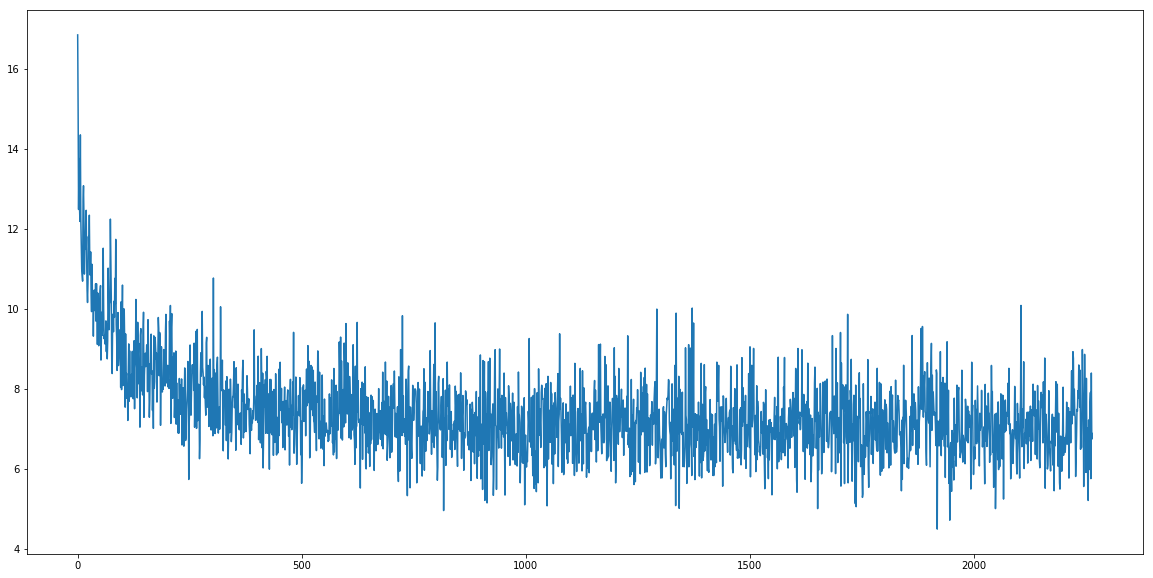

In [656]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(losses)

In [595]:

# how embedding works ?? 
# attention 
# teacher forcing




1) attention positional encoding